In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [ ]:
df = pd.read_parquet('train.parquet')
# X_oos = pd.read_parquet('X_oos.parquet')
# X_oot = pd.read_parquet("X_oot.parquet")
# y_oos = pd.read_parquet('y_oos.parquet')
# y_oot = pd.read_parquet("y_oot.parquet")
oos = pd.read_parquet('oos.parquet')
oot = pd.read_parquet('oot.parquet')

In [18]:
df.columns

Index(['C_GIOITINH', 'TRINHDO', 'TTHONNHAN', 'SOHUUNHA', 'NHANVIENBIDV',
       'BASE_AUM', 'TUOI', 'INCOME', 'CBAL', 'CBALORG', 'AFLIMT_MAX',
       'AFLIMT_MIN', 'AFLIMT_AVG', 'CBAL_AVG', 'CBAL_MAX', 'CBAL_MIN',
       'COLLATERAL_VALUE', 'LTV', 'N_AVG_DEPOSIT_12M', 'N_AVG_DEPOSIT_6M',
       'N_AVG_DD_12M', 'N_AVG_CD_12M', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT',
       'UTILIZATION_RATE', 'CNT_CREDIT_CARDS', 'AMT_CASH_ADVANCE_12M',
       'FLAG_CASH_ADVANCE', 'PCT_PAYMENT_TO_BALANCE', 'CNT_MIN_PAY_6M',
       'AVG_DAYS_PAST_DUE', 'DTI_RATIO', 'PTI_RATIO', 'MOB',
       'CNT_OTHER_PRODUCTS', 'LIMIT_TO_INCOME', 'AMT_VAR_6M',
       'CBAL_SHORTTERM_LOAN', 'CBAL_LONGTERM_LOAN', 'CNT_DPD_30PLUS_6M',
       'OCCUPATION_TYPE', 'DURATION_MAX', 'REMAINING_DURATION_MAX',
       'TIME_TO_OP_MAX', 'RATE_AVG', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_DPD_12M',
       'MAX_DPD_12M_OBS', 'AVG_OD_DPD_12M', 'SUM_ALL_OD_12M',
       'N_AVG_OVERDUE_CBAL_12M', 'CBAL_TO_INC_12MON', 'REAL_GDP_GROWTH_12M',
       'BAD

duplicated check 

In [19]:
df.duplicated().sum()

np.int64(0)

In [ ]:
oos.duplicated().sum()

np.int64(0)

In [ ]:
oot.duplicated().sum()

np.int64(0)

define target 

In [22]:
target_col = 'BAD_NEXT_12M'
feature_cols = [c for c in df.columns if c != target_col]

print(f"Tổng số biến cần EDA: {len(feature_cols)}")

Tổng số biến cần EDA: 54


bad rate ở từng tập 

In [ ]:
bad_rate_train = len(df[df['BAD_NEXT_12M'] == 1]) / len(df)
bad_rate_oos = len(oos[oos['BAD_NEXT_12M'] == 1]) / len(oos)
bad_rate_oot = len(oot[oot['BAD_NEXT_12M'] == 1]) / len(oot)

print(f"Bad rate tập train {bad_rate_train}")
print(f"Bad rate tập oos {bad_rate_oos}")
print(f"Bad rate tập oot {bad_rate_oot}")

Bad rate tập train 0.09595300433201764
Bad rate tập oos 0.0791896562632152
Bad rate tập oot 0.07617679477546481


#### Univariate Analysis

check datatype 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137807 entries, 0 to 1137806
Data columns (total 55 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   C_GIOITINH              1137807 non-null  object 
 1   TRINHDO                 1103538 non-null  float64
 2   TTHONNHAN               1137807 non-null  object 
 3   SOHUUNHA                1137807 non-null  int64  
 4   NHANVIENBIDV            1137807 non-null  int64  
 5   BASE_AUM                1137807 non-null  int64  
 6   TUOI                    1137807 non-null  int64  
 7   INCOME                  1081067 non-null  float64
 8   CBAL                    1137807 non-null  int64  
 9   CBALORG                 1137807 non-null  int64  
 10  AFLIMT_MAX              1137807 non-null  int64  
 11  AFLIMT_MIN              1137807 non-null  int64  
 12  AFLIMT_AVG              1137807 non-null  int64  
 13  CBAL_AVG                1137807 non-null  int64  
 14  CB

Các biến cần khi báo là cate khi binning: 
- Dạng object sẵn: C_GIOITINH, TTHONNHAN
- Dạng int: PURCOD_MAX, PURCOD_MIN, OCCUPATION_TYPE, TRINHDO, MAX_NHOMNOCIC

Check missing value

In [25]:
missing_report = df.isnull().mean().to_frame(name='missing_rate')
# Bỏ các biến missing > 70% (trừ phi có lý do nghiệp vụ)
vars_to_drop = missing_report[missing_report['missing_rate'] > 0.7].index.tolist()
print("Các biến bị loại do Missing quá nhiều:", vars_to_drop)

Các biến bị loại do Missing quá nhiều: []



- TRINHDO, INCOME, COLLATERAL_VALUE

optbinning sẽ tự động gom thành bin riêng 

Histogram/Density Plot

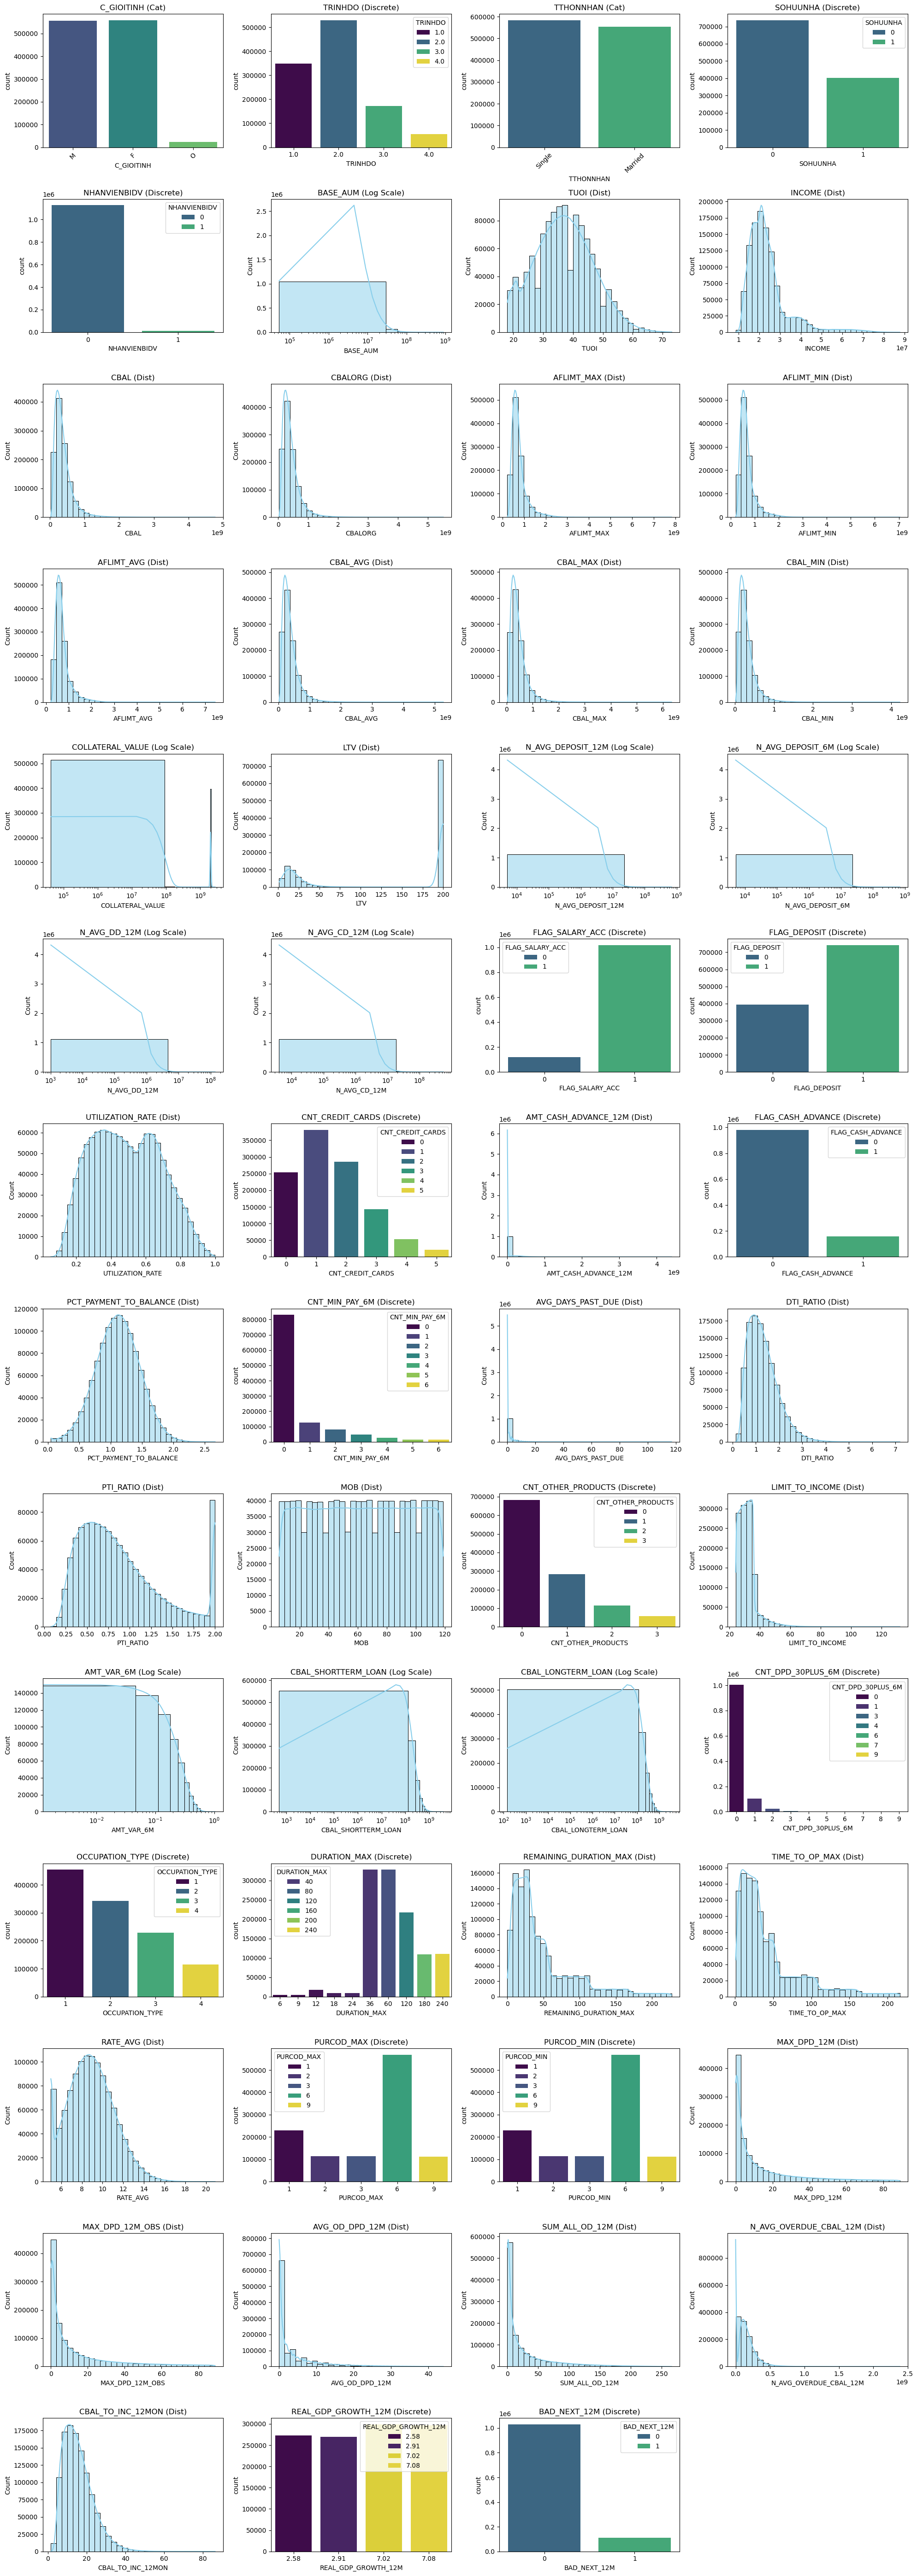

In [26]:
# 2. Cấu hình khung hình động (Dynamic Layout)
n_cols = 4  # Số biểu đồ trên 1 hàng (bạn có thể đổi thành 3 hoặc 5)
n_rows = math.ceil(len(df.columns) / n_cols)

plt.figure(figsize=(20, 4 * n_rows)) # Chiều cao tự dãn theo số lượng biến

# 3. Vòng lặp vẽ biểu đồ
for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # CASE A: Biến số (Numeric) -> Vẽ Histogram
    if pd.api.types.is_numeric_dtype(df[col]):
        # Nếu ít giá trị unique (VD: < 10) -> Coi như biến phân loại (Countplot)
        if df[col].nunique() < 15:
            sns.countplot(data=df, x=col, hue=col, palette='viridis')
            plt.title(f'{col} (Discrete)')
        else:
            # Vẽ Histogram + KDE
            sns.histplot(df[col], bins=30, kde=True, color='skyblue')
            plt.title(f'{col} (Dist)')
            
            # [Quan trọng] Tự động bật Log-scale nếu giá trị quá lớn (tiền tệ)
            # Logic: Nếu max > 100 lần min dương -> Scale Log cho dễ nhìn
            data_min = df[df[col] > 0][col].min()
            data_max = df[col].max()
            if data_min > 0 and (data_max / data_min > 1000):
                plt.xscale('log')
                plt.title(f'{col} (Log Scale)')
                
    # CASE B: Biến phân loại (Categorical/Object) -> Vẽ Countplot
    else:
        sns.countplot(data=df, x=col, hue=col, palette='viridis')
        plt.title(f'{col} (Cat)')
        plt.xticks(rotation=45) # Xoay nhãn nếu dài

plt.tight_layout()
plt.show()

kiểm tra outlier 

In [27]:
# 1. Xác định danh sách biến cần check (Biến số - trừ ID và Target)
exclude_cols = ['SOCIF', 'BAD_NEXT_12M', 'REF_MONTH', 'REF_DAY', 'year', 'SNAPSHOT_DATE', 'TRINHDO', 'OCCUPATION_TYPE', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_NHOMNOCIC', 'NHANVIENBIDV', 'SOHUUNHA', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT', 'FLAG_CASH_ADVANCE', 'BAD_CURRENT', 'XULYNO', 'HAS_SHORTTERM_LOAN', 'HAS_LONGTERM_LOAN']
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Loại bỏ các biến Flag (chỉ có 0 và 1) và biến ID
cols_to_check = [c for c in numeric_cols if c not in exclude_cols and df[c].nunique() > 10] 

# 2. Tạo báo cáo Outlier
outlier_report = []

for col in cols_to_check:
    # Tính các mốc thống kê
    p01 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    v_min = df[col].min()
    v_max = df[col].max()
    
    # Logic phát hiện nghi vấn:
    # 1. Max quá lớn so với P99 (Gấp 5 lần trở lên) -> Có thể là Outlier hoặc mã đặc biệt
    # 2. Min quá nhỏ (Số âm cho biến tiền tệ)
    
    is_suspicious = False
    note = ""
    
    # Check Max spike
    if (v_max > p99 * 5) and (v_max > 0): # Gấp 5 lần
        is_suspicious = True
        note += "Max cực lớn (Gap > 5x P99). "
        
    # Check Negative (cho biến tiền, trừ biến động có thể âm)
    if v_min < 0 and 'VAR' not in col: # VAR có thể âm
        is_suspicious = True
        note += "Có giá trị Âm. "

    if is_suspicious:
        outlier_report.append({
            'Variable': col,
            'Min': v_min,
            'P99': p99,
            'Max': v_max,
            'Max/P99 Ratio': round(v_max / p99 if p99 > 0 else 0, 1),
            'Note': note
        })

# 3. In kết quả
df_outlier = pd.DataFrame(outlier_report)
print(f"Tìm thấy {len(df_outlier)} biến có dấu hiệu Outlier mạnh:")
print(df_outlier.sort_values(by='Max/P99 Ratio', ascending=False))

Tìm thấy 7 biến có dấu hiệu Outlier mạnh:
               Variable    Min           P99         Max  Max/P99 Ratio  \
1     N_AVG_DEPOSIT_12M   5129  3.214021e+07   687732705           21.4   
2      N_AVG_DEPOSIT_6M   5129  3.214021e+07   687732705           21.4   
3          N_AVG_DD_12M   1025  6.428042e+06   137546541           21.4   
4          N_AVG_CD_12M   4104  2.571217e+07   550186164           21.4   
0              BASE_AUM  53429  8.386845e+07   883421932           10.5   
5  AMT_CASH_ADVANCE_12M      0  7.053942e+08  4399059484            6.2   
6     AVG_DAYS_PAST_DUE      0  1.900000e+01         117            6.2   

                           Note  
1  Max cực lớn (Gap > 5x P99).   
2  Max cực lớn (Gap > 5x P99).   
3  Max cực lớn (Gap > 5x P99).   
4  Max cực lớn (Gap > 5x P99).   
0  Max cực lớn (Gap > 5x P99).   
5  Max cực lớn (Gap > 5x P99).   
6  Max cực lớn (Gap > 5x P99).   


Các outlier này là ngoại lai tự nhiên (Natural Outliers) đặc trưng của dữ liệu tài chính, phản ánh sự phân hóa mạnh về thu nhập và hành vi khách hàng, không phải lỗi dữ liệu nên được giữ nguyên để đảm bảo tính phân loại. Các biến này sẽ được xử lý tự động thông qua thuật toán Optimal Binning, mà không cần xử lý thủ công 